In [8]:
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = datasets.load_iris() # vraca objekat koji sadrzi:
# data -> NumPy niz koji sadrzi vrednosti atributa
# target -> NumPy niz koji sadrži klase
# feature_names -> Lista imena atributa

columns = np.array(data.feature_names)
print(columns)
X = data.data 
print(X.shape)
y = data.target
print(y.shape)

data_values = np.concatenate((X, y.reshape((y.shape[0], 1))), axis=1)
iris_df = pd.DataFrame(data=data_values, columns=[col for col in columns] + ['class'])

['sepal length (cm)' 'sepal width (cm)' 'petal length (cm)'
 'petal width (cm)']
(150, 4)
(150,)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,      # 30% za test
    train_size=0.7,     # 70% za trening
    random_state=42,    
    stratify=y          # čuva odnos klasa
)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(105, 4) (45, 4)
(105,) (45,)


***Ensemble metode*** - su tehnike koje kombinuju više modela (obično slabijih) da bi zajedno dali bolje, stabilnije i tačnije predikcije nego bilo koji pojedinačni model

Problemi korišćenja jedno modela:
- model ima veliku varijansu (mnogo se menja kada se malo promene trening podaci - na primer Decision Tree bez ograničenja dubine)
- model je previše pristrasan (je previše jednostavan i ne može da uhvati složen obrazac - na primer linearna regresija na nelinearnim podacima) 

1) ***Bagging metode*** je ensemble metoda koja trenira više istih modela nezavisno, pri čemu svaki model dobija malo drugačije podatke, a konačna predikcija je agregacija (prosek / glasanje)

Rešava problem modela koji imaju veliku varijansu. Na primer Decision Tree bez ograničenja dubine savršeno nauči trening skup i zapamti šum, ali loše generalizuje. Takav model je jak, ali nestabilan.

Ideja: klasifikatori generisani korišćenjem različitih bootstrap uzoraka sa vraćanjem.

Algoritam: Ako imamo M istih modela, bira se M različitih uzoraka iz trening skupa na uniforman način sa vraćanjem. Valičina izabranog uzorka je manja od veličine trening skupa. Za svaki izabrani uzorak $i$ trenira se po jedan model $C_i$ nezavisno od ostalih modela. Krajnja klasa dobija se glasanjem/računanjem srednje vrednosti svih $C_i$ klasifikatora/modela regresije.

Svaka instanca iz trening skupa ima $1 - (1 - \frac{1}{m})^m \approx 63.2\% $ za veliko m, što znači da nije garantovano da će svaka instanca iz skupa biti uzeta izabrana. Ovo nije pogodno za stabilne klasifikatore (kao što je KNN) jer se manji skup podataka koristi za treniranje modela.

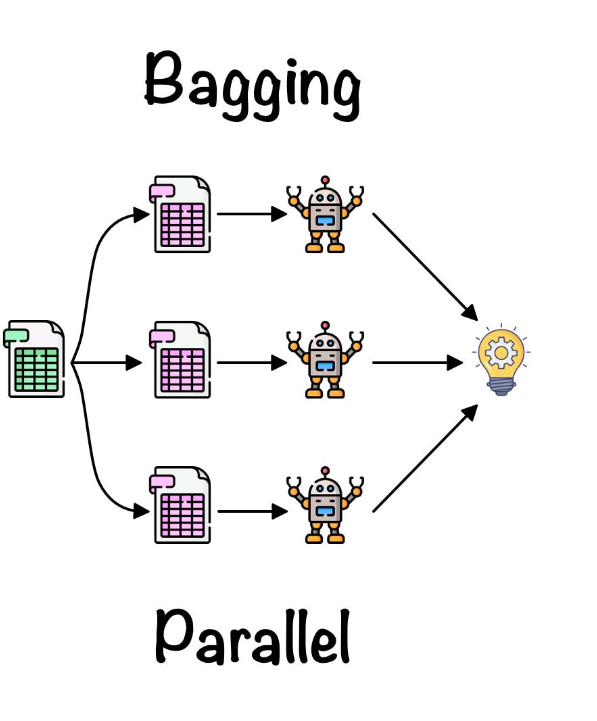

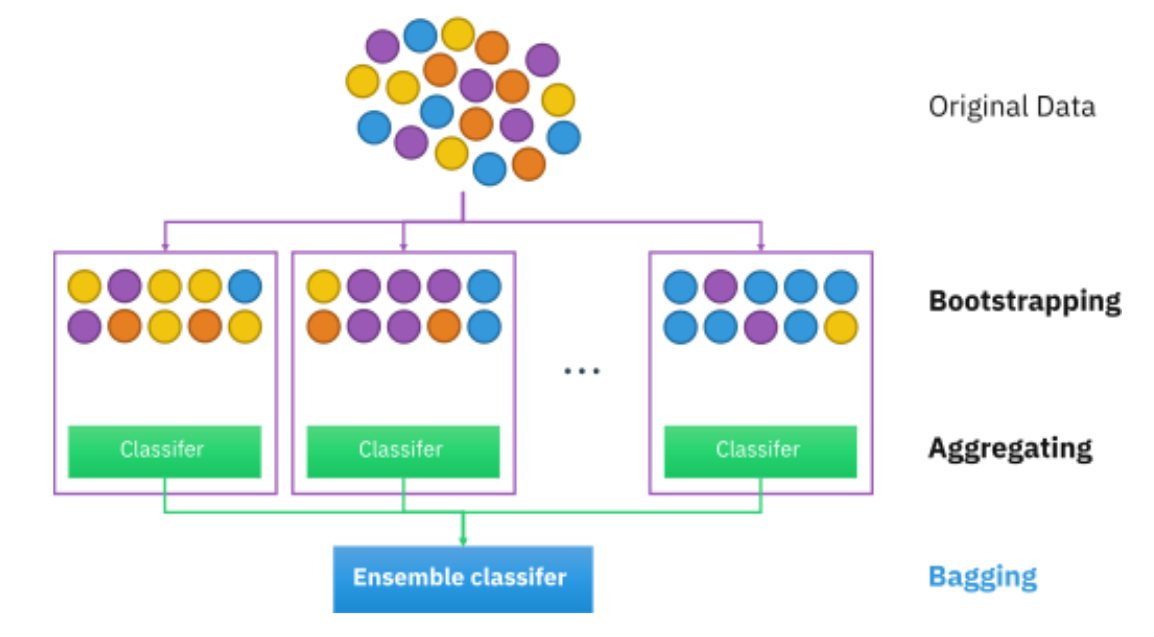

In [33]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(), # osnovni model
    n_estimators=100, # broj modela u ensemble-u
    random_state=42,
    bootstrap=True,  # da li se uzorkuje sa ponavljanjem
    max_samples=0.7,   # 70% podataka ide u svaki model, postavlja se 1 ako hocemo sve instance za treniranje svakog modela
    max_features= 3, # koliko atributa se uzima za razmatranje u svakom čvoru (m)
    bootstrap_features = True, # da li se atributi biraju sa ponavljanjem
    oob_score=True # dostupno je akko je bootstrap=True
)

bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)

In [34]:
print(bag.oob_score_)

0.9619047619047619


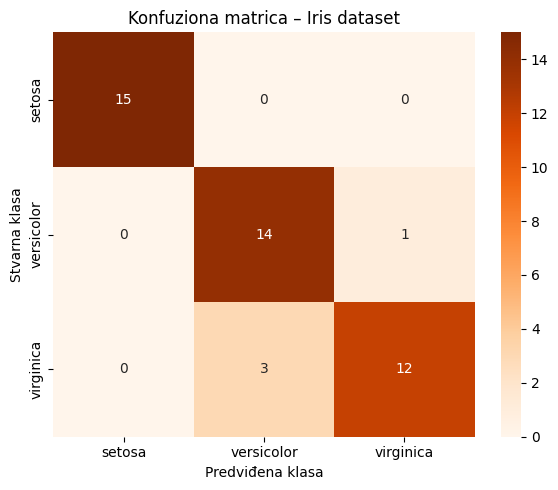

In [32]:
from sklearn.metrics import confusion_matrix

class_names = data.target_names
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=class_names,
    columns= class_names
)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Oranges')

plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Konfuziona matrica – Iris dataset')

plt.tight_layout()
plt.show()


Za regresiju se može koristiti BaggingRegressor ensemble metoda. Detalje pogledati https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

**Random Forest** - je tehnika kombinovanja:
- bagging metode
- feature subsampling: random odabir atributa koji razmatramo u čvoru, što osigurava razliku izmedju stabala

U slučaju da je broj odabranih atributa za čvor (m):
- m = 1 : na svakom se čvoru razmatra samo jedna osobina
- m = M : klasičan bagging
- m < M : po čvoru se razmatra podskup ($\frac{1}{2}M, \sqrt{M}, 2\sqrt{M})$
gde je M oznaka za broj atributa u celom skupu



"Out-of-bag" - obzirom da je Random Forest bagging tehnika, za svako drvo postoje instance iz trening skupa koje nismo uzeli za treniranje modela, stoga te instance možemo iskoristiti za validacioni skup svakog pojedinačnog drveta odlučivanja. 

In [36]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=100,    # broj stabala (bootstrap uzorci)
    criterion='gini',    # ili 'entropy'
    max_depth=None,      # bez ograničenja dubine
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

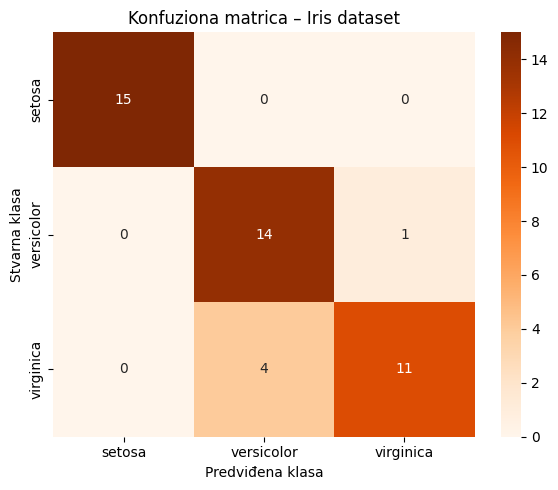

In [37]:
from sklearn.metrics import confusion_matrix

class_names = data.target_names
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=class_names,
    columns= class_names
)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Oranges')

plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Konfuziona matrica – Iris dataset')

plt.tight_layout()
plt.show()


In [39]:
from sklearn.metrics import accuracy_score
# Tačnost
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy za RandomForest: {accuracy:.4f}")

Accuracy za RandomForest: 0.8889


2) ***Boosting metode*** - su ensemble metode koje treniraju više modela sekvencijalno, pri čemu svaki model ispravlja greške prethodnih čime smanjuje bias.

Rešavaju problem modela koji imaju veliku pristrasnost (bias). Na primer, jednostavni modeli poput linearnih klasifikatora ne uspevaju da uhvate složene obrasce u podacima i dovode do underfitting-a. Takvi modeli su stabilni, ali preslabi.

Ideja:
Klasifikatori se treniraju sekvencijalno, pri čemu se svaki naredni model fokusira na uzorke koje prethodni modeli nisu dobro klasifikovali. Na taj način se postepeno gradi sve složeniji i snažniji model.

Algoritam:
Ako imamo M modela, u početku se svim uzorcima iz trening skupa dodeljuju jednake težine. Prvi model se trenira na celom skupu podataka. Nakon toga se povećavaju težine uzoraka koji su pogrešno klasifikovani, dok se težine ispravno klasifikovanih uzoraka smanjuju. Sledeći model se trenira koristeći ove nove težine, čime se više pažnje posvećuje „teškim“ primerima. Ovaj postupak se ponavlja M puta. Krajnja predikcija dobija se težinskim glasanjem (kod klasifikacije) ili težinskim sabiranjem (kod regresije) svih modela.

Model se gradi kao zbir slabih modela:

$F(x) = \sum_{t=1}^{T} \alpha_t h_t(x)
$

gde je:

-  $h_t(x)$ – slabi model (najčešće plitko stablo, npr. decision stump ili stablo male dubine)
- $\alpha_t$ – težina modela $h_t $, koja zavisi od njegove tačnosti
- $ T $ – ukupan broj iteracija, odnosno slabih modela


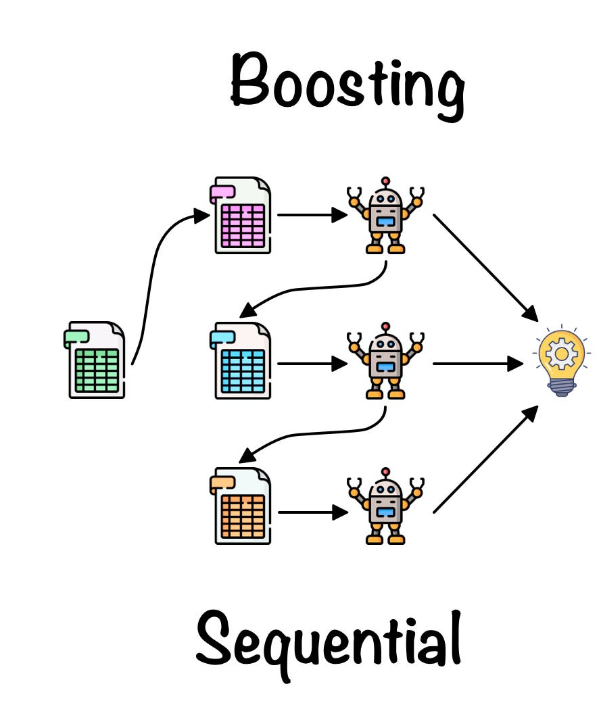

2.1) Boosting sa menjanjem težina uzoraka - ko je pogrešno klasifikovan dobija veću težinu  

**AdaBoost**

Mana: osetljiv na outlier-e i šum (jer će boosting forsirati da “ispravi” i šum

In [45]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_clf = DecisionTreeClassifier(max_depth=1, random_state=42)

# AdaBoost model
adaboost = AdaBoostClassifier(
    estimator=base_clf,
    n_estimators=50,       # broj slabih klasifikatora
    learning_rate=1.0,
    random_state=42
)

adaboost.fit(X_train, y_train)

,"estimator estimator: object, default=NoneThe base estimator from which the boosted ensemble is built.Support for sample weighting is required, as well as proper``classes_`` and ``n_classes_`` attributes. If ``None``, thenthe base estimator is :class:`~sklearn.tree.DecisionTreeClassifier`initialized with `max_depth=1`... versionadded:: 1.2 `base_estimator` was renamed to `estimator`.",DecisionTreeC...ndom_state=42)
,"n_estimators n_estimators: int, default=50The maximum number of estimators at which boosting is terminated.In case of perfect fit, the learning procedure is stopped early.Values must be in the range `[1, inf)`.",50
,"learning_rate learning_rate: float, default=1.0Weight applied to each classifier at each boosting iteration. A higherlearning rate increases the contribution of each classifier. There isa trade-off between the `learning_rate` and `n_estimators` parameters.Values must be in the range `(0.0, inf)`.",1.0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the random seed given at each `estimator` at eachboosting iteration.Thus, it is only used when `estimator` exposes a `random_state`.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",1
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None


In [47]:
y_pred = adaboost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy AdaBoost: {accuracy:.4f}")

Accuracy AdaBoost: 0.9333


2.2) Boosting koji modelira grešku prethodnog modela (rezidual), kao gradijentni spust u “prostoru funkcija”

**Gradient Boosting**

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting model
gbc = GradientBoostingClassifier(
    n_estimators=100,   # broj slabih klasifikatora (stabla)
    learning_rate=0.1,  # koliko novo stablo utiče na model
    max_depth=3,        # dubina svakog stabla
    random_state=42
)

gbc.fit(X_train, y_train)

,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, 

In [49]:
y_pred = gbc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Gradient Boosting: {accuracy:.4f}")

Accuracy Gradient Boosting: 0.9333


**XGBoost**

In [52]:
!pip install xgboost
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    use_label_encoder=False,  # za novije verzije XGBoost
    eval_metric='mlogloss',   # multiclass log loss
    random_state=42
)

# Treniranje
xgb_clf.fit(X_train, y_train)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 3.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 2.1 MB/s eta 0:00:00m eta 0:00:010:00:03


/home/marija/Desktop/IP2/IP2_venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [02:20:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [53]:
y_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy XGBoost: {accuracy:.4f}")

Accuracy XGBoost: 0.9333


**LightGBM**

In [54]:
!pip install lightgbm
import lightgbm as lgb

# LightGBM classifier
lgb_clf = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Treniranje
lgb_clf.fit(X_train, y_train)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 4.1 MB/s eta 0:00:00m eta 0:00:010:01:01
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83
[LightGBM] [Info] Number of data points in the train set: 105, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,3
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [55]:
y_pred = lgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy LightGBM: {accuracy:.4f}")

Accuracy LightGBM: 0.8444


/home/marija/Desktop/IP2/IP2_venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Mere za ocenu klasifikacije:

https://en.wikipedia.org/wiki/F-score#:~:text=Diagnostic%20testing%5Bedit%5D

In [58]:
y_proba = lgb_clf.predict_proba(X_test) # treba nam da bismo dobili $y_proba[i, k] = verovatnoća klase k za uzorak i$

/home/marija/Desktop/IP2/IP2_venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


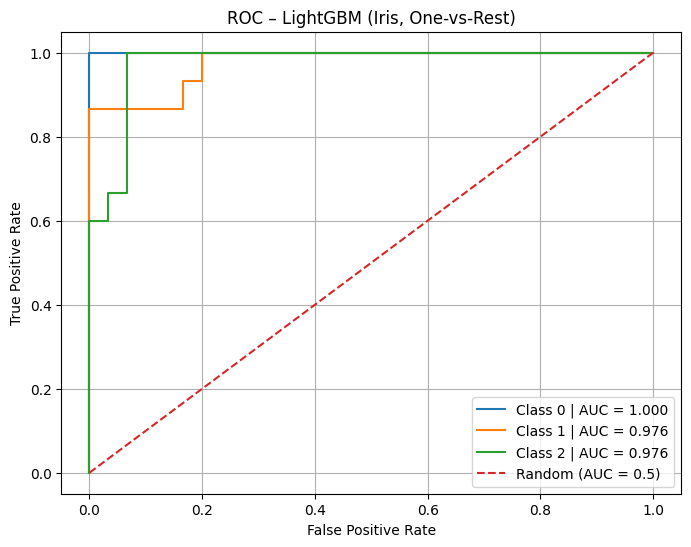

Macro AUC: 0.9837037037037039


In [60]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(8, 6))
auc_values = []

for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    auc_score = auc(fpr, tpr)
    auc_values.append(auc_score)

    plt.plot(
        fpr, tpr,
        label=f"Class {cls} | AUC = {auc_score:.3f}"
    )

plt.plot([0, 1], [0, 1], linestyle="--", label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – LightGBM (Iris, One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()

print("Macro AUC:", np.mean(auc_values)) # Ako nasumično izaberem klasu, koliko je model u proseku dobar u razlikovanju te klase od svih ostalih?